In [61]:
# Import libraries

# Data Processing
import numpy as np
import pandas as pd

# Data Visuals
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocess
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer, WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# Machine Learning package
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

# Model Training and Evaluations
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
#from xgboost import XGBClassifier

# Metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

# Joblib to Export ML Model
import joblib

## Data and Visualization

The Data that we will be looking at is the (MBTI) Myer-Briggs Personality Type Dataset. It contains over 8600 rows of data, which the columns being the type of the user, and the second column being the last 50 things they have posted (with each post being separated by "|||"). 

In [2]:
# Read Data
data = pd.read_csv("mbti_1.csv")
data.head()

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...


In [3]:
# Check if there are any nulls, check the shape
print("Check for Nulls:")
print(data.isnull().any())
print("\nData Shape:")
print(data.shape)
print("\nData Info:")
print(data.info())

Check for Nulls:
type     False
posts    False
dtype: bool

Data Shape:
(8675, 2)

Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8675 entries, 0 to 8674
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   type    8675 non-null   object
 1   posts   8675 non-null   object
dtypes: object(2)
memory usage: 135.7+ KB
None


In [4]:
# Check the unique entires in column type
types = np.unique(np.array(data['type']))
types

array(['ENFJ', 'ENFP', 'ENTJ', 'ENTP', 'ESFJ', 'ESFP', 'ESTJ', 'ESTP',
       'INFJ', 'INFP', 'INTJ', 'INTP', 'ISFJ', 'ISFP', 'ISTJ', 'ISTP'],
      dtype=object)

In [5]:
total = data.groupby(['type']).count()*50 # Multiply by 50 since there are 50 posts per entry
total_sorted = data.groupby(['type']).count().sort_values(['posts'], ascending=False)*50
print(total)
print("")
print(total_sorted)

      posts
type       
ENFJ   9500
ENFP  33750
ENTJ  11550
ENTP  34250
ESFJ   2100
ESFP   2400
ESTJ   1950
ESTP   4450
INFJ  73500
INFP  91600
INTJ  54550
INTP  65200
ISFJ   8300
ISFP  13550
ISTJ  10250
ISTP  16850

      posts
type       
INFP  91600
INFJ  73500
INTP  65200
INTJ  54550
ENTP  34250
ENFP  33750
ISTP  16850
ISFP  13550
ENTJ  11550
ISTJ  10250
ENFJ   9500
ISFJ   8300
ESTP   4450
ESFP   2400
ESFJ   2100
ESTJ   1950


Text(0.5, 1.0, 'Total Posts for Each Personality Type')

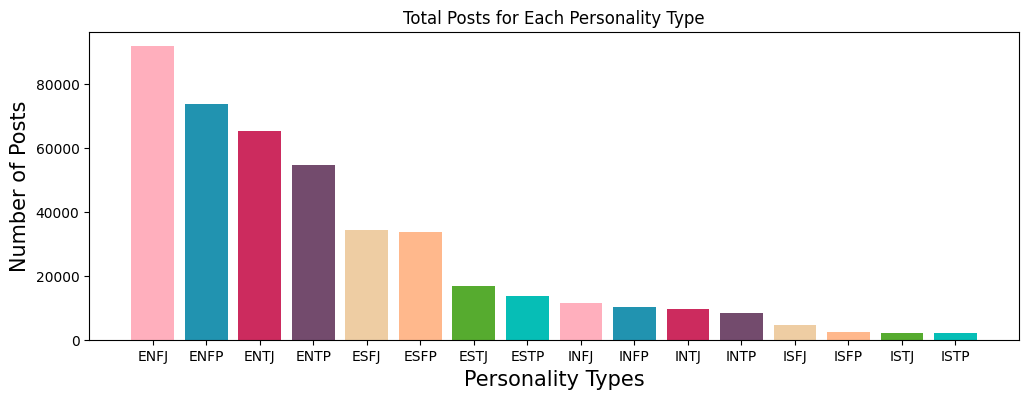

In [33]:
matplotlib_colors = ['#ffafbd', '#2193b0', '#cc2b5e', '#734b6d', '#eecda3', '#ffb88c', '#56ab2f', '#06beb6'] # Colors from: https://digitalsynopsis.com/design/beautiful-color-ui-gradients-backgrounds/

# Visual barchart of total posts for each personality type, sorted by post count
plt.figure(figsize = (12,4))
plt.bar(np.array(total.index), height = total_sorted['posts'], color=matplotlib_colors)
plt.xlabel('Personality Types', size = 15)
plt.ylabel('Number of Posts', size = 15)
plt.title('Total Posts for Each Personality Type')

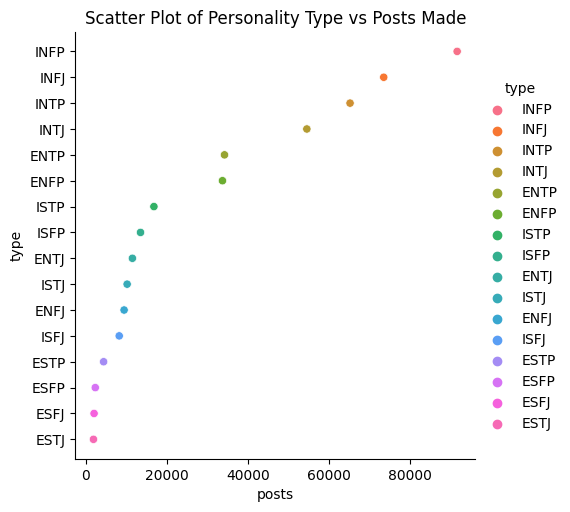

In [54]:
# Another visual representation, this time via Seaborn ScatterPlot, total posts for each personality type, sorted by post count
sns.color_palette("hls", 8)
sns.relplot(
    data=total_sorted,
    x="posts", y="type", hue="type"
).set(title='Scatter Plot of Personality Type vs Posts Made')

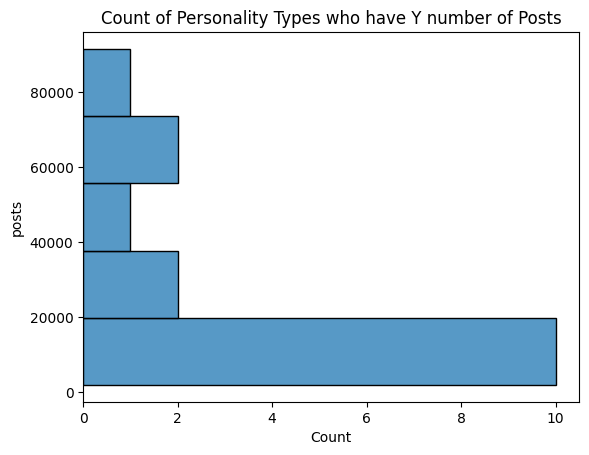

In [40]:
# Visual Represntation of Count of Personality Types of who have certain number of posts
typecount_histogram = sns.histplot(y="posts", data=total).set(title='Count of Personality Types who have Y number of Posts')

## Initial Pre-processing

I will do pre-processing on the data in order to make it readable for the machine learning models. This involves removing links, punctuation, stopwords, converting to lowercase, and getting rid of the mbti personality tags within the data itself. I will also remove posts that have less than 20 words, because it is more difficult to determine personality from short posts.

I will do pre-processing on the data in order to make it readable for the machine learning models. This involves removing links, punctuation, stopwords, 

In [59]:
# Preprocess 

# Code from: https://www.kaggle.com/code/rajshreev/mbti-personality-predictor-using-machine-learning

def preprocess_text(df, remove_special=True):
    texts = df['posts'].copy()
    labels = df['type'].copy()

    #Remove links 
    df["posts"] = df["posts"].apply(lambda x: re.sub(r'https?:\/\/.*?[\s+]', '', x.replace("|"," ") + " "))
    
    #Keep the End Of Sentence characters
    df["posts"] = df["posts"].apply(lambda x: re.sub(r'\.', ' EOSTokenDot ', x + " "))
    df["posts"] = df["posts"].apply(lambda x: re.sub(r'\?', ' EOSTokenQuest ', x + " "))
    df["posts"] = df["posts"].apply(lambda x: re.sub(r'!', ' EOSTokenExs ', x + " "))
    
    #Strip Punctation
    df["posts"] = df["posts"].apply(lambda x: re.sub(r'[\.+]', ".",x))

    #Remove multiple fullstops
    df["posts"] = df["posts"].apply(lambda x: re.sub(r'[^\w\s]','',x))

    #Remove Non-words
    df["posts"] = df["posts"].apply(lambda x: re.sub(r'[^a-zA-Z\s]','',x))

    #Convert posts to lowercase
    df["posts"] = df["posts"].apply(lambda x: x.lower())

    #Remove multiple letter repeating words
    df["posts"] = df["posts"].apply(lambda x: re.sub(r'([a-z])\1{2,}[\s|\w]*','',x)) 

    #Remove very short or long words
    df["posts"] = df["posts"].apply(lambda x: re.sub(r'(\b\w{0,3})?\b','',x)) 
    df["posts"] = df["posts"].apply(lambda x: re.sub(r'(\b\w{30,1000})?\b','',x))

    #Remove MBTI Personality Words - crutial in order to get valid model accuracy estimation for unseen data. 
    if remove_special:
        pers_types = ['INFP' ,'INFJ', 'INTP', 'INTJ', 'ENTP', 'ENFP', 'ISTP' ,'ISFP' ,'ENTJ', 'ISTJ','ENFJ', 'ISFJ' ,'ESTP', 'ESFP' ,'ESFJ' ,'ESTJ']
        pers_types = [p.lower() for p in pers_types]
        p = re.compile("(" + "|".join(pers_types) + ")")
    
    return df

#Preprocessing of entered Text
data_preprocessed = preprocess_text(data)

In [60]:
# Removing posts with less than 20 words
min_words = 20
print("Before : Number of posts", len(data_preprocessed)) 
data_preprocessed["no. of. words"] = data_preprocessed["posts"].apply(lambda x: len(re.findall(r'\w+', x)))
data_preprocessed = data_preprocessed[data_preprocessed["no. of. words"] >= min_words]

print("After : Number of posts", len(data_preprocessed))

Before : Number of posts 8675
After : Number of posts 8425


### Encoding

Encoding in this case refers to transforming the data from categorical text variables into a numerical format so that it is understood by the machines. In this case, we had the option of choosing OneHotEncoder and LabelEncoder. OneHotEncoder changes each of the types into a whole seperate feature column, so it would add 16 columns because there are 16 unique MBTI types. This would increase the dimensionality and increase the complexity, so I have chosen to go with LabelEncoder. LabelEncoder basically turns each type into a number. In the example below, you can see INFJ = 8, ENTP = 2, etc. So there will be 16 numbers, and each one represents an MBTI type. 

In [80]:
# OneHot Encoder was a potential option. However, LabelEncoder was chosen over it because of the simplicity, and the fact were 16 categories would make it slow to run
onehot = OneHotEncoder()
oh = onehot.fit_transform(data_preprocessed['type'].values.reshape(-1, 1))
oh

<8425x16 sparse matrix of type '<class 'numpy.float64'>'
	with 8425 stored elements in Compressed Sparse Row format>

In [82]:
# Using Label Encoder
enc = LabelEncoder()
data_preprocessed['type of encoding'] = enc.fit_transform(data_preprocessed['type'])

target = data_preprocessed['type of encoding'] 

data_preprocessed.head()

C:\Users\Eternal\AppData\Local\Temp\ipykernel_14608\103244890.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_preprocessed['type of encoding'] = enc.fit_transform(data_preprocessed['type'])


,type,posts,no. of. words,type of encoding
0,INFJ,enfp intj moments sportscenter plays...,430,8
1,ENTP,finding lack these posts very alarming eo...,803,3
2,INTP,good course which know thats bles...,253,11
3,INTJ,dear intp enjoyed conversation other eos...,777,10
4,ENTJ,youre fired eostokendot thats another silly...,402,2


### CounterVectorizer and TF-IDF

In [83]:
# Vectorizing the posts for the model and filtering Stop-words
vect = CountVectorizer(stop_words='english') 

# Converting posts (or training or X feature) into numerical form by count vectorization
train =  vect.fit_transform(data_preprocessed["posts"])
train.shape

(8425, 98546)

In [84]:
X_train, X_test, y_train, y_test = train_test_split(train, target, test_size=0.3, stratify=target, random_state=611)
print ((X_train.shape),(y_train.shape),(X_test.shape),(y_test.shape))

(5897, 98546) (5897,) (2528, 98546) (2528,)


### Testing out Pipeline with Standard Scaler and Logistic Regression

After pre-processing, I explored Logistic Regression as my first machine learning model. When I first tried it, I failed to converge because it said "lbfgs failed to converse need higher max_iter or to use alternative solver options". According to sources online, SAGA solver is said to be the best choice for LogReg models. There were still issues, and setting the max_iter to 5000 made the process take an enormous amount of time (I could not finish it). Sources also say that scaled data is recommended in LogReg. So I utilized a pipeline with the first step being StandardScaler. You can see below that this actually proved to lower the accuracy compared to the original Logistic Regression model. Despite having some warnings with the LogReg being unable to converge, the accuracy for the original LogReg still proved to be decent at 59%.

In [85]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [86]:
# lbfgs failed to converse, need higher max_iter or to use alternative solver options

# According to StackOverflow, SAGA solver is often the best choice
# https://stackoverflow.com/questions/38640109/logistic-regression-python-solvers-definitions#:~:text=The%20SAGA%20solver%20is%20a,theoretical%20convergence%20compared%20to%20SAG.

# Setting max_iter to 5000 made the process take over 3 mins...

# StackOverflow recommends the use of scaled data
# https://stackoverflow.com/questions/57085897/python-logistic-regression-max-iter-parameter-is-reducing-the-accuracy

accuracies = {}

# Normal LogReg
logreg = LogisticRegression(solver='saga', max_iter=700)
logreg.fit(X_train, y_train)

Y_pred = logreg.predict(X_test)
predictions = [round(value) for value in Y_pred]

# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
accuracies['Logistic Regression'] = accuracy* 100.0
print("Accuracy (LogReg): %.2f%%" % (accuracy * 100.0))

Accuracy: 59.34%


c:\Users\Eternal\Downloads\ENSF Masters\ENSF 611\Project\ml-mbti-fullstack\server\venv\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [93]:
# Pipeline Initialization

# Error for StandardScaler: "Cannot center sparse matrices: pass `with_mean=False` instead. See docstring for motivation and alternatives."
pipeline = Pipeline(steps=[('scaling', StandardScaler(with_mean=False)), ('classifier', LogisticRegression(solver='saga', max_iter=700))])
pipeline

Pipeline(steps=[('scaling', StandardScaler(with_mean=False)),
                ('classifier',
                 LogisticRegression(max_iter=700, solver='saga'))])

In [88]:
# Pipeline
pipeline.fit(X_train, y_train)

Y_pred = pipeline.predict(X_test)
predictions = [round(value) for value in Y_pred]

accuracy = accuracy_score(y_test, predictions)
accuracies['Pipeline with Scaler and LR'] = accuracy* 100.0
print("Pipeline (SS+LogReg) Accuracy: %.2f%%" % (accuracy * 100.0))

Pipeline (SS+LogReg) Accuracy: 33.15%


c:\Users\Eternal\Downloads\ENSF Masters\ENSF 611\Project\ml-mbti-fullstack\server\venv\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [ ]:
# Pipeline Initialization

# Error for StandardScaler: "Cannot center sparse matrices: pass `with_mean=False` instead. See docstring for motivation and alternatives."
pipeline = Pipeline(steps=[('scaling', StandardScaler(with_mean=False)), ('classifier', LogisticRegression(solver='saga', max_iter=700))])
pipeline

pipeline.fit(X_train, y_train)

Y_pred = pipeline.predict(X_test)
predictions = [round(value) for value in Y_pred]

accuracy = accuracy_score(y_test, predictions)
accuracies['Pipeline with Scaler and LR'] = accuracy* 100.0
print("Pipeline (SS+LogReg) Accuracy: %.2f%%" % (accuracy * 100.0))

In [95]:
pd.DataFrame.from_dict(accuracies, orient='index', columns=['Accuracies (%)'])

,Accuracies (%)
Logistic Regression,59.335443
Pipeline with Scaler and LR,33.148734


#### Results from the LogisticRegression Tests

From the Accuracy Table above, it looks like the Pipeline with StandardScaler and LogisticRegression performed significantly worse than just LogisticRegression by itself. Both LogReg used the same SAGA solver and identical max_iter=700 values. The addition of the StandardScaler reduced the accuracy. Although multiple StackOverflow posts said that LogReg prefers the use of Scaled data, it seems like it did not work well in this case because it is a text-related problem. Standard Scaler aims to standardize features by removing the mean. Likely, does not have a positive effect on this text-reliant inputs.

## Further Pre-processing

As outlined in the 'MBTI Kaggle Notebook' that I am following, the author went through multiple ML models but was unable to get an accurate result even after changing the training/testing data distributions. The reasoning for this is likely that the model must choose between 1 of 16 classifications. Intuitively, this is very difficult to do. A more effective solution would be to split each letter of the Type it into four sections. 

- Introversion (I) | Extroversion (E)
- Intuition (N) | Sensing (S)
- Thinking (T) | Feeling (F)
- Judging (J) | Perception (P)

For example, INTJ would be I, N, T, and J. Now with this, the model does not have to choose INTJ from the 16 classifcations directly. The model would choose I from I/E, N from N/S, T from T/F, and J from J/P.

Even if they predict a personality type of INTP (one less off from INTJ), that is still quite accurate. Additioanlly, another positive of this separation is that it is easier to train the model. As shown later in the Notebook, we can train the machine learning model four times, one for each section (I/E, N/S, T/F, and J/P).

In [96]:
# Per Lab W14, preprocessing for text includes:
# Normalizing count (tf-idf)
# Reduce the vocab (remove stop-words, stemming/lemmatization)
# N-grams

# Download NLTK packages
nltk.download('stopwords') # Stopwords
nltk.download('wordnet') # Wordnet
nltk.download('omw-1.4') # Open Multilingual Wordnet

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Eternal\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Eternal\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Eternal\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

### Stemming vs. Lemmatization Explanation

Stemming and Lemmatization are methods to obtain the derived word so that it can be compared to other similar words with the same root. Stemming simply cut off parts of words to achieve a 'stem' of the word. Although this is very quick, it sometimes leads to inaccuracies. Lemmatization, on the other hand, is more proper and uses vocabulary analysis of the word to determine if words are similar or not. Although Lemmatization is usually more difficult, it will lead to greater accuracies if implemented.

Source: https://nlp.stanford.edu/IR-book/html/htmledition/stemming-and-lemmatization-1.html

In [99]:
# Initialize Word Lemmatization
lemmatiser = WordNetLemmatizer()

# Initialize Stopwords
stops = stopwords.words('english')

### List/Dictionary Explanation

There is a list called unique_type_list which contains a list of all 16 types contained in teh dataset. This is converted to lowercase, and is used in the preprocessing function defined later to remove all instances of the mbti words in the post. 

There is also two dictionaries. 
One contains the the key-value pair of letter to number. This converts from letters to binary. For example, INFJ would be [0 0 0 0].
The second contains an array of 4 dictionaries, with the key being the binary value, and the value being the letter. This can convert from Binary to Letters. For example [0 0 0 0] would be converted to I N F J as a string.

Finally there are two functions that handle converting MBTI to binary, and binary back to MBTI.

In [113]:
# Remove these from the posts
# unique_type_list = ['INFJ', 'ENTP', 'INTP', 'INTJ', 'ENTJ', 'ENFJ', 'INFP', 'ENFP', 'ISFP', 'ISTP', 'ISFJ', 'ISTJ', 'ESTP', 'ESFP', 'ESTJ', 'ESFJ']
unique_type_list = data['type'].unique().tolist() # Rather than doing above, can find all unique 'types' from the dataset
unique_type_list = [x.lower() for x in unique_type_list] # Change to lowercase

# Dictionary of each personality type in Binary. For example, I = 0, E = 1.
# Given a Letter as a Key, convert to Binary Value
b_Pers = {'I':0, 'E':1, 'N':0, 'S':1, 'F':0, 'T':1, 'J':0, 'P':1}

# Given a Binary Number as a Key, find the Associated Value
b_Pers_list = [{0:'I', 1:'E'}, {0:'N', 1:'S'}, {0:'F', 1:'T'}, {0:'J', 1:'P'}]

# Transform MBTI to Binary Vector form
def translate_personality(personality):
    return [b_Pers[l] for l in personality]

# Transform Binary Vector back to MBTI Personality
def translate_back(personality):
    s = ""
    for i, l in enumerate(personality):
        s += b_Pers_list[i][l]
    return s

# Example Below:
list_personality_bin = np.array([translate_personality(p) for p in data.type])
print("Binarized MBTI list for Entire Dataset: \n%s" % list_personality_bin)

list_personality_type = np.array([translate_back(p) for p in list_personality_bin])
print("Translated Back MBTI list: \n%s" % list_personality_type)

Binarized MBTI list for Entire Dataset: 
[[0 0 0 0]
 [1 0 1 1]
 [0 0 1 1]
 ...
 [0 0 1 1]
 [0 0 0 1]
 [0 0 0 1]]
Translated Back MBTI list: 
['INFJ' 'ENTP' 'INTP' ... 'INTP' 'INFP' 'INFP']


We can once again do further pre-processing. This function is fairly similar to the one above, but it handles the four different categories of the type.

In [114]:
# Further pre-processing

# Code from: https://www.kaggle.com/code/rajshreev/mbti-personality-predictor-using-machine-learning

def pre_process_text(data, remove_stop_words=True, remove_mbti_profiles=True):
  list_personality = []
  list_posts = []
  
  for row in data.iterrows():

      #Remove and clean comments
      posts = row[1].posts

      #Remove url links 
      temp = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', ' ', posts)

      #Remove Non-words - keep only words
      temp = re.sub("[^a-zA-Z]", " ", temp)

      # Remove spaces > 1
      temp = re.sub(' +', ' ', temp).lower()

      #Remove multiple letter repeating words
      temp = re.sub(r'([a-z])\1{2,}[\s|\w]*', '', temp)

      #Remove stop words
      if remove_stop_words:
          temp = " ".join([lemmatiser.lemmatize(w) for w in temp.split(' ') if w not in stops])
      else:
          temp = " ".join([lemmatiser.lemmatize(w) for w in temp.split(' ')])
          
      #Remove MBTI personality words from posts
      if remove_mbti_profiles:
          for t in unique_type_list:
              temp = temp.replace(t,"")

      # transform mbti to binary vector
      type_labelized = translate_personality(row[1].type)
      list_personality.append(type_labelized)
      # the cleaned data temp is passed here
      list_posts.append(temp)

  # returns the result
  list_posts = np.array(list_posts)
  list_personality = np.array(list_personality)
  return list_posts, list_personality

In [115]:
list_posts, list_personality  = pre_process_text(data, remove_stop_words=True, remove_mbti_profiles=True)

print("Example :")
print("\nPost before preprocessing:\n\n", data.posts[0])
print("\nPost after preprocessing:\n\n", list_posts[0])
print("\nMBTI before preprocessing:\n\n", data.type[0])
print("\nMBTI after preprocessing:\n\n", list_personality[0])

Example :

Post before preprocessing:

     enfp  intj moments   sportscenter    plays   pranks   what  been  most lifechanging experience  your life eostokenquest        repeat  most  today eostokendot      perc experience immerse  eostokendot     last thing  infj friend posted   facebook before committing suicide  next  eostokendot  rest  peace     hello enfj eostokendot  sorry  hear  your distress eostokendot   only natural   relationship    perfection   time  every moment  existence eostokendot    figure  hard times  times  growth  eostokendot  eostokendot  eostokendot          eostokendot  eostokendot  eostokendot    welcome  stuff eostokendot     game eostokendot   eostokendot  match eostokendot    prozac wellbrutin  least thirty minutes  moving your legs   dont mean moving them while sitting  your same desk chair weed  moderation maybe  edibles   healthier alternative eostokendot  eostokendot  eostokendot    basically come  with three items youve determined that each type  which

### CounterVectorizer and TF-IDF

CountVectorizer will make the posts turn into a bag-of-words, which means that there will be a matrix with the colmuns being the text, and the count of that word in the rows.

TF-IDF is a weighting factor that evaluates the relevancy of a word in a post compared to all the other posts. This helps with context of the posts.

In [118]:
# Vectorizing the database posts to a matrix of token counts for the model
cntizer = CountVectorizer(analyzer="word", 
                             max_features=1000,  
                             max_df=0.7,
                             min_df=0.1) 
# the feature should be made of word n-gram 
# Learn the vocabulary dictionary and return term-document matrix

print("Using CountVectorizer :")
X_cnt = cntizer.fit_transform(list_posts)

#The enumerate object yields pairs containing a count and a value (useful for obtaining an indexed list)
feature_names = list(enumerate(cntizer.get_feature_names_out()))
print("10 feature names can be seen below")
print(feature_names[10:20])

print("CNTIZER Shape:",X_cnt.shape)

# For the Standardization or Feature Scaling Stage :-
# Transform the count matrix to a normalized tf or tf-idf representation
tfizer = TfidfTransformer()

# Learn the idf vector (fit) and transform a count matrix to a tf-idf representation
print("\nUsing Tf-idf :")

print("Now the dataset size is as below")
X_tfidf =  tfizer.fit_transform(X_cnt).toarray()
print("TFIDF Shape:",X_tfidf.shape)

Using CountVectorizer :
10 feature names can be seen below
[(10, 'along'), (11, 'already'), (12, 'also'), (13, 'although'), (14, 'always'), (15, 'amazing'), (16, 'amount'), (17, 'angry'), (18, 'another'), (19, 'answer')]
CNTIZER Shape: (8675, 533)

Using Tf-idf :
Now the dataset size is as below
TFIDF Shape: (8675, 533)


In [125]:
personality_type = [ "IE: Introversion (I) | Extroversion (E)", "NS: Intuition (N) | Sensing (S)", 
                   "FT: Feeling (F) | Thinking (T)", "JP: Judging (J) | Perceiving (P)"  ]

for p_type in personality_type:
    print(p_type)

print("\nFor MBTI personality type : %s" % translate_back(list_personality[5,:]))
print("Y : Binarized MBTI 1st row: %s" % list_personality[5,:])

IE: Introversion (I) | Extroversion (E)
NS: Intuition (N) | Sensing (S)
FT: Feeling (F) | Thinking (T)
JP: Judging (J) | Perceiving (P)

For MBTI personality type : INTJ
Y : Binarized MBTI 1st row: [0 0 1 0]


In [126]:
# Make X = the transformed tfidf data matrix
X = X_tfidf

### Machine Learning

We can start on the machine learning after completing the final pre-processing step. I wanted to explore the RandomForest classification model. As advised by the Kaggle Notebook, I will be training and testing the model for each of the four categories (ex. I/E, N/S, etc.). Then for each iteration, the model will predict and append the binary form of the MBTI type to the list. Using the list, we can convert back to the MBTI in letter format.

In [129]:
#Random Forest model for MBTI dataset
# Individually training each mbti personlity type
results = []
for l in range(len(personality_type)):
    
    Y = list_personality[:,l]

    # split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=8)

    # fit model on training data
    model = RandomForestClassifier()
    model.fit(X_train, y_train)

    # make predictions for test data
    y_pred = model.predict(X_test)
    results.append(y_pred[0])
    
    predictions = [round(value) for value in y_pred]
    # evaluate predictions
    accuracy = accuracy_score(y_test, predictions)
    
    print("%s Accuracy: %.2f%%" % (personality_type[l], accuracy * 100.0))

IE: Introversion (I) | Extroversion (E) Accuracy: 77.10%
NS: Intuition (N) | Sensing (S) Accuracy: 85.56%
FT: Feeling (F) | Thinking (T) Accuracy: 68.81%
JP: Judging (J) | Perceiving (P) Accuracy: 60.62%


In [132]:
print("Binary Result:", results)
print("Predicted MBTI: ", translate_back(results))

Binary Result: [0, 0, 0, 1]
Predicted MBTI:  INFP


### Testing the Model before Production

After creating the RF model, I want to test it out using a string to see how it would take in an input to predict the MBTI. This will be useful when using the model in the backend. my_posts contains a string that we want to put through the model. Since the machine learning models do not accept string by itself, we must make it a pd.DataFrame and pass it through that way. There is dummy data as the type, just so the preprocess function can be used. Then, the data is passed through CountVectorizer, then it is transformed via TF-IDF Transformer.

In [165]:
my_posts = """ NO ONE CHANGES THE WORLD ALONE. 
It's a simple truth, but a powerful one. And it's a sentiment that has guided me my entire life. It's what led me to Chicago as a young man, eager to make a difference but unsure how to do it, searching for mentors and a community that I might be able to help out. It's what sustained my campaigns and my time in the White House—the support of millions of people who shared the belief that lasting change can only come from the bottom up. And it's the idea that Michelle and I have devoted our lives to through our Foundation, an organization committed to inspiring, empowering, and connecting people with the voice and the vision for a better tomorrow.
Because the world can use more leaders. I saw that clearly during my time in the White House, and I believe that even more today. When global progress is halted, it's not because we lack the solutions to our problems. People don't go hungry because we don't know how to grow food. Children don't die because we lack cures to common diseases. Schools don't fail because we don't know how to provide a quality education.
We face these and other challenges, as unique as they are, for a similar reason: because we need the kind of inclusive, ethical leadership that can channel a people's will into progress that benefits everyone. We need fresh eyes and diverse perspectives that can help us question and change our current ways of thinking.
That's why the Obama Foundation is supporting emerging leaders throughout the world—because we believe that the community leaders of today will become the global leaders of tomorrow.
And I don't just mean politicians and presidents.
Leadership is necessary at all levels of a society. We need more grassroots leaders who are willing to go into their communities to ensure everyone's voice is heard. We need more entrepreneurs and private sector executives who understand that enriching their communities and workforce can be just as valuable as enriching their shareholders. We need more advocates who are willing to challenge systems of oppression and ensure that potential is met with opportunity, regardless of race or gender, culture or creed, orientation or belief.
We need more jurists and thinkers and scientists and engineers and artists and everyday people, everywhere, to step up, realize our fates are intertwined, and help lead us into a brighter future.
Those are the leaders of tomorrow that we seek to prepare today.
Throughout these pages, you'll see how the Obama Foundation is working to identify and support those leaders, whether it's amplifying the impact of established changemakers like our Fellows and Scholars, offering substantive training programs to emerging voices in communities at home or regions abroad, or breaking down barriers for boys and young men of color in the U.S. and girls around the world so that they can thrive and lead as well.
To me, the stories that really stand out are the stories of connection—young men and young women who've met each other through the Foundation's work and have been able to improve people's lives in dramatic new ways as a result.
These are connections that would not otherwise exist— Scholars from Asia, Leaders from Africa, Fellows from Europe, college students from Chicago—all forming bonds that will support and enrich them for years to come. Some met during the course of our programming. Some met during our 2018 Summit.
Some will soon meet through a digital network we're building. And many, many more will meet at the Obama Presidential Center, a campus that will attract people from around the world, while honoring Chicago's history as a crucible for change.
Today they all know that they're not alone as they pursue progress.
And in the days and years ahead, they will change the world—together. """

# Letter Source: https://www.obama.org/annual-report-2018/letter-president-obama/

# The type is just a dummy so that the data prep function can be reused
mydata = pd.DataFrame(data={'type': ['INFJ'], 'posts': [my_posts]})
mydata.head()


,type,posts
0,INFJ,NO ONE CHANGES THE WORLD ALONE.\nIt's a simpl...


In [166]:
my_posts, dummy  = pre_process_text(mydata, remove_stop_words=True, remove_mbti_profiles=True)

print("Pre-processed Post:\n", my_posts)

my_X_cnt = cntizer.transform(my_posts)
my_X_tfidf =  tfizer.transform(my_X_cnt).toarray()

Pre-processed Post:
 [' one change world alone simple truth powerful one sentiment guided entire life led chicago young man eager make difference unsure searching mentor community might able help sustained campaign time white house support million people shared belief lasting change come bottom idea michelle devoted life foundation organization committed inspiring empowering connecting people voice vision better tomorrow world use leader saw clearly time white house believe even today global progress halted lack solution problem people go hungry know grow food child die lack cure common disease school fail know provide quality education face challenge unique similar reason need kind inclusive ethical leadership channel people progress benefit everyone need fresh eye diverse perspective help u question change current way thinking obama foundation supporting emerging leader throughout world believe community leader today become global leader tomorrow mean politician president leadership 

In [185]:
test_results = []

for l in range(len(personality_type)):
    
    Y = list_personality[:,l]

    # split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.35, random_state=7)

    model = RandomForestClassifier()    
    # fit model on training data
    model.fit(X_train, y_train)

    # make predictions for test data
    y_pred = model.predict(my_X_tfidf)
    print(y_pred)
    test_results.append(y_pred[0])

print(test_results)
print("The result is: ", translate_back(test_results))
print("Train Score:",model.score(X_train, y_train))
print("Test Score:",model.score(X_test, y_test))

[0]
[0]
[1]
[1]
[0, 0, 1, 1]
The result is:  INTP
Train Score: 0.9959205391982973
Test Score: 0.6160684886401053


## RandomSearchCV

The Original RandomForest predicted the author of the above letter to be INTP. The letter was from Former President of the United States, Barack Obama. According to source on the internet, he is sepculated to be ENTP. Perhaps we can try to make the model more accurate by changing the hyper-parameters. Originally I used GridSearchCV, however since I need to run the model four times, this was taking an extremely long time. I settled for RandomSearchCV and only changed two hyper-parameters. I set the RandomSearchCV n_iter to be only 50. For more accurate results, it should be higher. But even with those settings, the run-time code around 5 minutes.

In [153]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

# Param Grid for RF: https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 800, num = 3)]
max_depth = [int(x) for x in np.linspace(10, 50, num = 3)]
max_depth.append(None)

min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]

random_grid = dict(n_estimators=n_estimators, max_depth=max_depth)
print(random_grid)

{'n_estimators': [200, 500, 800], 'max_depth': [10, 30, 50, None]}


In [154]:
# WARNING: SECTION TAKES 4-5 MINUTES TO RUN
for l in range(len(personality_type)):
    
    Y = list_personality[:,l]

    # split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.30, random_state=7)

    model2 = RandomForestClassifier()    

    rf_random = RandomizedSearchCV(estimator = model2, param_distributions = random_grid, n_iter = 50, cv = 3, verbose=2, random_state=611, n_jobs = -1)
    # fit model on training data
    grid_result = rf_random.fit(X_train, y_train)

    print(grid_result.best_score_, grid_result.best_params_)

c:\Users\Eternal\Downloads\ENSF Masters\ENSF 611\Project\ml-mbti-fullstack\server\venv\lib\site-packages\sklearn\model_selection\_search.py:306: UserWarning: The total space of parameters 12 is smaller than n_iter=50. Running 12 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 3 folds for each of 12 candidates, totalling 36 fits
0.767292490118577 {'n_estimators': 200, 'max_depth': 10}
Fitting 3 folds for each of 12 candidates, totalling 36 fits


c:\Users\Eternal\Downloads\ENSF Masters\ENSF 611\Project\ml-mbti-fullstack\server\venv\lib\site-packages\sklearn\model_selection\_search.py:306: UserWarning: The total space of parameters 12 is smaller than n_iter=50. Running 12 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0.8619894598155468 {'n_estimators': 200, 'max_depth': 10}
Fitting 3 folds for each of 12 candidates, totalling 36 fits


c:\Users\Eternal\Downloads\ENSF Masters\ENSF 611\Project\ml-mbti-fullstack\server\venv\lib\site-packages\sklearn\model_selection\_search.py:306: UserWarning: The total space of parameters 12 is smaller than n_iter=50. Running 12 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0.7033926218708828 {'n_estimators': 500, 'max_depth': 50}
Fitting 3 folds for each of 12 candidates, totalling 36 fits


c:\Users\Eternal\Downloads\ENSF Masters\ENSF 611\Project\ml-mbti-fullstack\server\venv\lib\site-packages\sklearn\model_selection\_search.py:306: UserWarning: The total space of parameters 12 is smaller than n_iter=50. Running 12 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0.6049077733860342 {'n_estimators': 500, 'max_depth': 30}


### Results from RandomSearchCV for RandomForest

The results from the above code block is as follows:

- Iteration 1 (I/E): 0.767292490118577 {'n_estimators': 200, 'max_depth': 10}
- Iteration 2 (N/S): 0.8619894598155468 {'n_estimators': 200, 'max_depth': 10}
- Iteration 3 (F/T): 0.7033926218708828 {'n_estimators': 500, 'max_depth': 50}
- Iteration 4 (J/P): 0.6049077733860342 {'n_estimators': 500, 'max_depth': 30}

I was originally thinking of initializing a new RandomForest() for every iteration, but I did not think that it would work, so I settled on choosing the best hyper-parameers that would give the best score for all four. I settled on n_estimators = 200 and max_depth = 10.

In [188]:
test_results_bestrf = []

for l in range(len(personality_type)):
    
    Y = list_personality[:,l]

    # split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.35, random_state=7)

    model_bestrf = RandomForestClassifier(n_estimators=300, max_depth=15)    
    # fit model on training data
    model_bestrf.fit(X_train, y_train)

    # make predictions for test data
    y_pred = model.predict(my_X_tfidf)
    print(y_pred)
    test_results_bestrf.append(y_pred[0])

print(test_results_bestrf)
print("The result is: ", translate_back(test_results_bestrf))

[1]
[1]
[1]
[1]
[1, 1, 1, 1]
The result is:  ESTP


In [189]:
print("Original RF Score:")
print(model.score(X_train, y_train))
print(model.score(X_test, y_test))

print("\nBest RF Score:")
print(model_bestrf.score(X_train, y_train))
print(model_bestrf.score(X_test, y_test))

Original RF Score:
0.9959205391982973
0.6160684886401053

Best RF Score:
0.9395175594182334
0.6111294040171221


From the above accuracies, it looks like changing the hyper-parameters did not increase the accuracy of the model. In fact, it decreased it (at least on this seed). However, it does seem to be over-fitting a bit less since the training score has lowered. To obtain a better model, we can add more parameters to the grid, increase the options of each parameters, increase the iterations of RandomSearchCV, or use GridSearchCV. However, these are all time-consuming options. For now, I will export this RandomForest model via joblib. I will also use joblib to dump the trained CountVectorized and TF-IDF Transformer. 

In [190]:
joblib.dump(model_bestrf, 'rfbestmbticlassifier.joblib')
joblib.dump(cntizer, 'cntizer.pkl')
joblib.dump(tfizer, 'tfizer.pkl')

['tfizer.pkl']

## Another Model?!

At this point, I have used Logistic Regression for the first pre-processed set of Data, then I moved onto RandomForest where I also attempted to find the best model via GridSearch. The RandomForest model had a test score of 61%. I am not satisfied with this accuracy and would like to explore another model that can more accurately handle text. According to various sources, SVM seems to be great at handling these problems.

In [191]:
for l in range(len(personality_type)):
    
    Y = list_personality[:,l]

    # split data into train and test sets
    X_train3, X_test3, y_train3, y_test3 = train_test_split(X, Y, test_size=0.30, random_state=7)

    model3 = SVC()

    model3.fit(X_train3, y_train3)

    print("")
    print("Train",model3.score(X_train3, y_train3))
    print("Test",model3.score(X_test3, y_test3))

0.8354743083003953
0.774490971955436
0.8664361001317523
0.8620822128313484
0.9323122529644269
0.7241644256626969
0.8990447957839263
0.6296580868228967


In [199]:
# Source: https://medium.com/all-things-ai/in-depth-parameter-tuning-for-svc-758215394769
gamma = [0.1, 1, 10, 100]
C = [0.1, 1, 10, 100]
kernel = ['linear', 'rbf', 'poly']

random_grid_svc = dict(gamma=gamma, C=C, kernel=kernel)
print(random_grid_svc)

{'gamma': [0.1, 1, 10, 100], 'C': [0.1, 1, 10, 100], 'kernel': ['linear', 'rbf', 'poly']}


In [200]:
for l in range(len(personality_type)):
    
    Y = list_personality[:,l]

    # split data into train and test sets
    X_train3, X_test3, y_train3, y_test3 = train_test_split(X, Y, test_size=0.30, random_state=7)

    SVC_random = RandomizedSearchCV(estimator = model3, param_distributions = random_grid_svc, n_iter = 80, cv = 3, verbose=2, random_state=611, n_jobs = -1)
    # fit model on training data
    grid_result = SVC_random.fit(X_train3, y_train3)

    print(grid_result.best_score_, grid_result.best_params_)

c:\Users\Eternal\Downloads\ENSF Masters\ENSF 611\Project\ml-mbti-fullstack\server\venv\lib\site-packages\sklearn\model_selection\_search.py:306: UserWarning: The total space of parameters 48 is smaller than n_iter=80. Running 48 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 3 folds for each of 48 candidates, totalling 144 fits
0.767292490118577 {'kernel': 'linear', 'gamma': 0.1, 'C': 0.1}
Fitting 3 folds for each of 48 candidates, totalling 144 fits


c:\Users\Eternal\Downloads\ENSF Masters\ENSF 611\Project\ml-mbti-fullstack\server\venv\lib\site-packages\sklearn\model_selection\_search.py:306: UserWarning: The total space of parameters 48 is smaller than n_iter=80. Running 48 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0.8621541501976284 {'kernel': 'poly', 'gamma': 10, 'C': 0.1}
Fitting 3 folds for each of 48 candidates, totalling 144 fits


c:\Users\Eternal\Downloads\ENSF Masters\ENSF 611\Project\ml-mbti-fullstack\server\venv\lib\site-packages\sklearn\model_selection\_search.py:306: UserWarning: The total space of parameters 48 is smaller than n_iter=80. Running 48 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0.7137681159420289 {'kernel': 'rbf', 'gamma': 1, 'C': 1}
Fitting 3 folds for each of 48 candidates, totalling 144 fits


c:\Users\Eternal\Downloads\ENSF Masters\ENSF 611\Project\ml-mbti-fullstack\server\venv\lib\site-packages\sklearn\model_selection\_search.py:306: UserWarning: The total space of parameters 48 is smaller than n_iter=80. Running 48 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0.6154479578392622 {'kernel': 'poly', 'gamma': 1, 'C': 1}


### Results from RandomSearchCV for SVC

The results from the above code block is as follows:

- Iteration 1 (I/E): 0.767292490118577 {'kernel': 'linear', 'gamma': 0.1, 'C': 0.1}
- Iteration 2 (N/S): 0.8621541501976284 {'kernel': 'poly', 'gamma': 10, 'C': 0.1}
- Iteration 3 (F/T): 0.7137681159420289 {'kernel': 'rbf', 'gamma': 1, 'C': 1}
- Iteration 4 (J/P): 0.6154479578392622 {'kernel': 'poly', 'gamma': 1, 'C': 1}

The best parameters for the SVC seem to be all of the place. It is difficult to choose one for each hyper-parameter. However, I will go with kernel='poly', gamma=1, C=1 as the best model.

In [206]:
for l in range(len(personality_type)):
    
    Y = list_personality[:,l]

    # split data into train and test sets
    X_train4, X_test4, y_train4, y_test4 = train_test_split(X, Y, test_size=0.30, random_state=7)

    model4 = SVC(kernel='poly', gamma=1, C=1)

    model4.fit(X_train4, y_train4)

    print("")
    print("Train",model4.score(X_train4, y_train4))
    print("Test",model4.score(X_test4, y_test4))


Train 0.9680500658761528
Test 0.7752593161736457

Train 0.961133069828722
Test 0.8620822128313484

Train 0.9836956521739131
Test 0.7095658855167115

Train 0.9830368906455863
Test 0.635036496350365


In [207]:
print("Original SVC Score:")
print(model3.score(X_train3, y_train3))
print(model3.score(X_test3, y_test3))

print("\nBest SVC Score:")
print(model4.score(X_train4, y_train4))
print(model4.score(X_test4, y_test4))

Original SVC Score:
0.8990447957839263
0.6296580868228967

Best SVC Score:
0.9830368906455863
0.635036496350365


### SVC Results

From the results above, it looks like the Best SVC performs about 0.5% better than the Original SVC, and also performs about 1-2% better than RandomForest. Although the accuracy remains quite low, it is still our best model. We can export it using joblib and utilize it on the Flask server.

In [208]:
joblib.dump(model4, 'svcbestmbticlassifier.joblib')

['svcbestmbticlassifier.joblib']